<a href="https://colab.research.google.com/github/RomaZhm/ColabNotes/blob/main/NNhomework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Загружаем файлы с данными**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Импортируем библиотеки**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
dfTrain = pd.read_csv('/content/drive/MyDrive/NNhomework/training.csv')
dfTest = pd.read_csv('/content/drive/MyDrive/NNhomework/test.csv')

**Описание данных**

In [ ]:
dfTrain.head(3)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...


In [ ]:
dfTrain.shape

(7049, 31)

В обучающей выборке 7049 рядов данных с 31 колонками. В 30 колонках указаны параметры, которые необходимо предсказать-координаты "ключевых точек" на лице. В последней колонке находятся сами изображения лиц людей.

**Задача**
Обучить нейросеть для предсказания ключевых точек лица на тестовой выборке. Для решения будет применяться свёрточная нейронная сеть.

**Предобработка данных перед обучением**

In [ ]:
dfTrain.isnull().any()

left_eye_center_x             True
left_eye_center_y             True
right_eye_center_x            True
right_eye_center_y            True
left_eye_inner_corner_x       True
left_eye_inner_corner_y       True
left_eye_outer_corner_x       True
left_eye_outer_corner_y       True
right_eye_inner_corner_x      True
right_eye_inner_corner_y      True
right_eye_outer_corner_x      True
right_eye_outer_corner_y      True
left_eyebrow_inner_end_x      True
left_eyebrow_inner_end_y      True
left_eyebrow_outer_end_x      True
left_eyebrow_outer_end_y      True
right_eyebrow_inner_end_x     True
right_eyebrow_inner_end_y     True
right_eyebrow_outer_end_x     True
right_eyebrow_outer_end_y     True
nose_tip_x                   False
nose_tip_y                   False
mouth_left_corner_x           True
mouth_left_corner_y           True
mouth_right_corner_x          True
mouth_right_corner_y          True
mouth_center_top_lip_x        True
mouth_center_top_lip_y        True
mouth_center_bottom_

In [ ]:
dfTrain.isnull().any().value_counts()

True     28
False     3
dtype: int64

В 28 разных столбцах можно найти отсутствующие значения, нужно заполнить их

In [ ]:
dfTrain.fillna(method = 'ffill',inplace = True)
dfTrain.isnull().any().value_counts()

False    31
dtype: int64

**Отделим изображения от "ключевых точек"**

In [ ]:
images = []
for idx, sample in dfTrain.iterrows():
   image = np.array(sample['Image'].split(' '), dtype=int)
   image = np.reshape(image, (96,96))
   images.append(image)
images = np.array(images)/255.

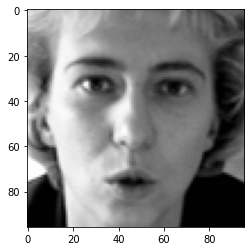

In [ ]:
plt.imshow(images[1].reshape(96,96),cmap='gray')

**Построение изображения с размеченными "ключевыми точками" на лице**

In [ ]:
dfTrain['Image'] = dfTrain['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

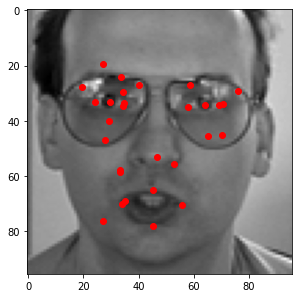

In [ ]:
rand = np.random.randint(0,20)
fig = plt.figure(figsize=(32, 32))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.1, wspace=0.1)
ax = fig.add_subplot(8, 8, 1)
image = plt.imshow(dfTrain['Image'][rand],cmap='gray')
l = []
for i in range(1,30):
    l.append(plt.plot(dfTrain.loc[rand][i-1], dfTrain.loc[rand][i], 'ro'))
plt.show()

**Разделяем данные для обучения модели**

In [ ]:
image_list = np.array(images,dtype = 'float')
X_train = image_list.reshape(-1,96,96,1)

training = dfTrain.drop('Image',axis = 1)
Y_train = []
for i in range(0,7049):
    y = training.iloc[i,:]
    Y_train.append(y)
Y_train = np.array(Y_train,dtype = 'float')

**Создаем модель свёрточной нейросети**

In [ ]:
from keras.layers.advanced_activations import ReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [ ]:
model = Sequential()

model.add(Convolution2D(32, (3,3), activation = 'relu', padding='same', use_bias=False, 
                        input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3,3), activation = 'relu', padding='same', use_bias=False))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), activation = 'relu', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3), activation = 'relu', padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae', 'acc'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
batch_normalization_51 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 48, 48, 32)        9216      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 24, 64)        18432     
_________________________________________________________________
batch_normalization_52 (Batc (None, 24, 24, 64)       

In [ ]:
history = model.fit(X_train, Y_train, epochs = 60,batch_size = 128,validation_split = 0.2)

Epoch 1/60
45/45 [==============================] - 2s 52ms/step - loss: 278.4994 - mae: 10.8146 - acc: 0.2887 - val_loss: 2824.9951 - val_mae: 49.2642 - val_acc: 0.0000e+00
Epoch 2/60
45/45 [==============================] - 2s 52ms/step - loss: 42.6512 - mae: 5.0960 - acc: 0.3577 - val_loss: 2754.7100 - val_mae: 48.7639 - val_acc: 0.0050
Epoch 3/60
45/45 [==============================] - 2s 47ms/step - loss: 35.6453 - mae: 4.6469 - acc: 0.3830 - val_loss: 2158.0107 - val_mae: 43.2746 - val_acc: 0.0071
Epoch 4/60
45/45 [==============================] - 2s 48ms/step - loss: 32.6836 - mae: 4.4418 - acc: 0.4174 - val_loss: 1253.8169 - val_mae: 32.8751 - val_acc: 0.0000e+00
Epoch 5/60
45/45 [==============================] - 2s 48ms/step - loss: 29.6305 - mae: 4.2122 - acc: 0.4471 - val_loss: 745.9677 - val_mae: 25.1871 - val_acc: 0.0021
Epoch 6/60
45/45 [==============================] - 2s 48ms/step - loss: 25.9944 - mae: 3.9346 - acc: 0.4692 - val_loss: 530.3140 - val_mae: 21.0859 - 

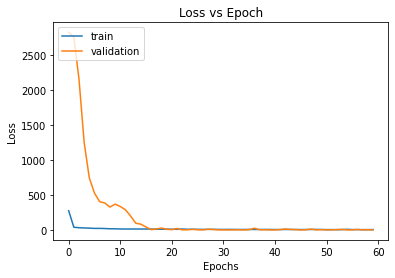

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
def process_img(data):
    images = []
    for idx, sample in data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

In [ ]:
y_test = process_img(dfTest)
preds = model.predict(y_test)

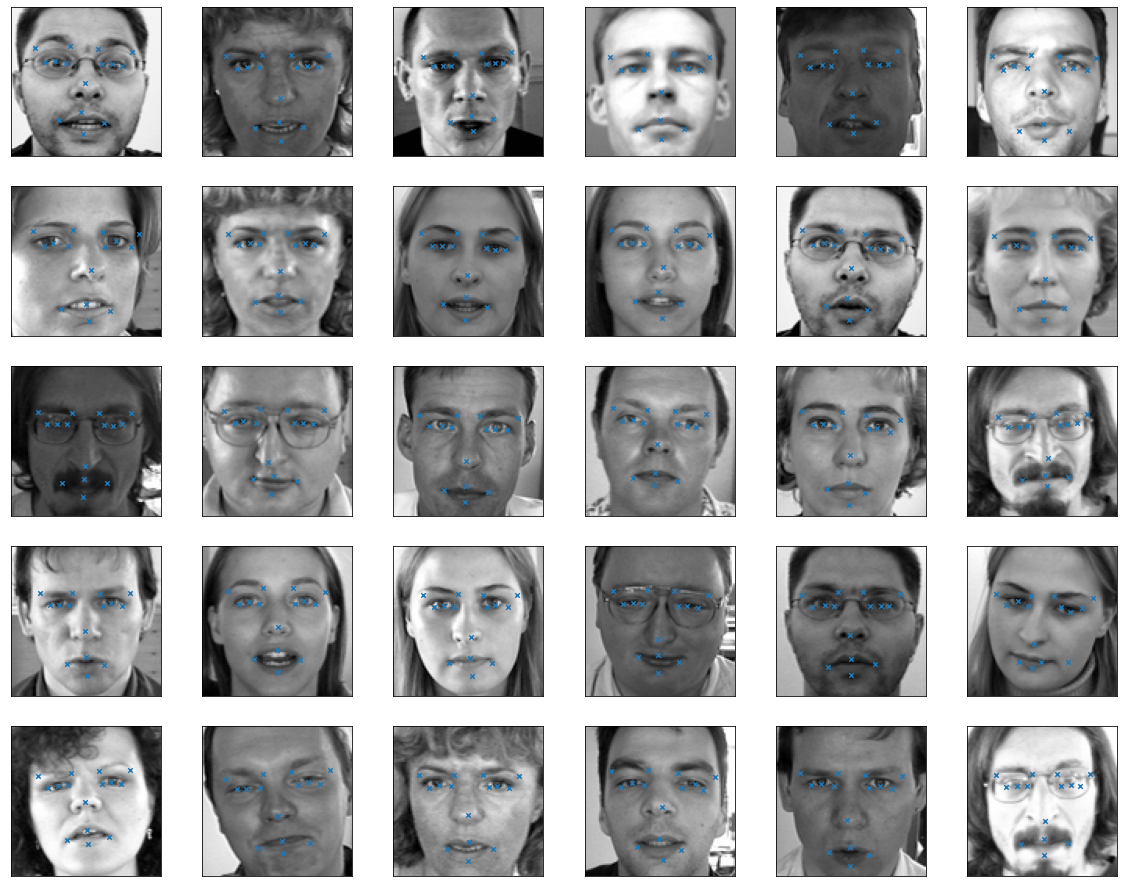

In [ ]:
fig = plt.figure(figsize=(20,16))
for i in range(30):
    axis = fig.add_subplot(5, 6, i+1, xticks=[], yticks=[])
    plot_sample(y_test[i], preds[i], axis, "")
plt.show()

**Заключение**
Мы наблюдаем, что модель обучилась достаточно хорошо, но при наклонённой голове или лице точки могут отклоняться от необходимого положения